**Общая информация**

**Срок сдачи:** 29 марта 2021, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_openml, fetch_20newsgroups

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KDTree
from sklearn.metrics import accuracy_score

#from scipy.spatial import distance
from sklearn.metrics.pairwise import pairwise_distances

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

%matplotlib inline

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [2]:
class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors=2, algorithm='brute', metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
        self.metric = metric
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
    
    def predict(self, X):
        if self.algorithm == 'brute':
            distances = pairwise_distances(X, self.X_train, self.metric)
            num_test = X.shape[0]
            y_pred = np.zeros(num_test)

            for i in range(num_test):
                y_indices = np.argsort(distances[i, :])
                k_closest_classes = self.y_train[y_indices[:self.n_neighbors]].astype(int)
                #k_closest_classes = np.take(self.y_train, y_indices[:self.k])
                y_pred[i] = np.argmax(np.bincount(k_closest_classes))

            return y_pred.astype(int)

        if self.algorithm == 'kd_tree':
            tree = KDTree(self.X_train)
            dist, y_ind = tree.query(X_test, k = self.n_neighbors)
            num_test = X_test.shape[0]
            y_pred = np.zeros(num_test)

            for i in range(num_test):
                k_closest_classes = self.y_train[y_ind[i]].astype(int)
                y_pred[i] = np.argmax(np.bincount(k_closest_classes))

            return y_pred.astype(int)


**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [6]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [7]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [8]:
# 1 ms = 1000 µs
# ms - миллисекунды
# µs - микросекунды
%time clf.fit(X_train, y_train)

CPU times: user 260 µs, sys: 48 µs, total: 308 µs
Wall time: 267 µs


KNeighborsClassifier(algorithm='brute', n_neighbors=2)

In [9]:
%time my_clf.fit(X_train, y_train)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


In [10]:
%time clf.predict(X_test)

CPU times: user 1.12 ms, sys: 474 µs, total: 1.59 ms
Wall time: 1.22 ms


array([0, 1, 0, 1, 2, 2, 0, 2, 1, 0, 1, 1, 1, 0, 2])

In [11]:
%time my_clf.predict(X_test)

CPU times: user 759 µs, sys: 377 µs, total: 1.14 ms
Wall time: 828 µs


array([0, 1, 0, 1, 2, 2, 0, 2, 1, 0, 1, 1, 1, 0, 2])

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [12]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [13]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [14]:
%time clf.fit(X_train, y_train)

CPU times: user 442 µs, sys: 80 µs, total: 522 µs
Wall time: 499 µs


KNeighborsClassifier(algorithm='kd_tree', n_neighbors=2)

In [15]:
%time my_clf.fit(X_train, y_train)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 6.2 µs


In [16]:
%time clf.predict(X_test)

CPU times: user 1.21 ms, sys: 404 µs, total: 1.62 ms
Wall time: 1.25 ms


array([1, 2, 2, 0, 2, 1, 0, 2, 0, 2, 1, 1, 0, 1, 0])

In [17]:
%time my_clf.predict(X_test)

CPU times: user 529 µs, sys: 243 µs, total: 772 µs
Wall time: 654 µs


array([1, 2, 2, 0, 2, 1, 0, 2, 0, 2, 1, 1, 0, 1, 0])

In [18]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [19]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [20]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [21]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [22]:
kf = KFold(n_splits=3)

my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = target[train_index], target[test_index]
    my_clf.fit(X_train, y_train)
    my_clf_pred = my_clf.predict(X_test)
    print(accuracy_score(y_test, my_clf_pred))


0.19034994697773064
0.19066560594006896
0.18164942985945373


Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [23]:
def find_best_n(metric='euclidean'):
    scores_array = []
    for k in range(1, 11):
        kf = KFold(n_splits=3)
        my_clf = MyKNeighborsClassifier(n_neighbors=k, algorithm='brute', metric=metric)
        '''
        scores = []
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = target[train_index], target[test_index]
            my_clf.fit(X_train, y_train)
            predict = my_clf.predict(X_test)
            accuracy = accuracy_score(predict, y_test)
            scores.append(accuracy)
        scores = np.mean(scores)
        '''
        scores = cross_val_score(my_clf, X, target, cv = kf, scoring='accuracy')
        scores_array.append(scores.mean())
        print('for k = {} mean accuracy among all folds: {}'.format(k, scores.mean()))
    return scores_array

In [24]:
scores1 = find_best_n()

for k = 1 mean accuracy among all folds: 0.20850286820809474
for k = 2 mean accuracy among all folds: 0.18755499425908442
for k = 3 mean accuracy among all folds: 0.18463862883933393
for k = 4 mean accuracy among all folds: 0.18092664816862966
for k = 5 mean accuracy among all folds: 0.18340137225176342
for k = 6 mean accuracy among all folds: 0.1829595434413754
for k = 7 mean accuracy among all folds: 0.18499239184567837
for k = 8 mean accuracy among all folds: 0.18649499412222859
for k = 9 mean accuracy among all folds: 0.18941175792374298
for k = 10 mean accuracy among all folds: 0.1913560952737956


Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

In [25]:
scores2 = find_best_n(metric='cosine')

for k = 1 mean accuracy among all folds: 0.29238085971534544
for k = 2 mean accuracy among all folds: 0.27205146173768124
for k = 3 mean accuracy among all folds: 0.2686929159942217
for k = 4 mean accuracy among all folds: 0.26542257666013414
for k = 5 mean accuracy among all folds: 0.2625946988604126
for k = 6 mean accuracy among all folds: 0.2581754733876764
for k = 7 mean accuracy among all folds: 0.2579985684502828
for k = 8 mean accuracy among all folds: 0.2555238912355919
for k = 9 mean accuracy among all folds: 0.2529606560982078
for k = 10 mean accuracy among all folds: 0.24712738627161443


In [26]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data)

In [27]:
scores3 = find_best_n(metric='euclidean')

for k = 1 mean accuracy among all folds: 0.15078630249136707
for k = 2 mean accuracy among all folds: 0.11446000195535144
for k = 3 mean accuracy among all folds: 0.10738910059364508
for k = 4 mean accuracy among all folds: 0.10208586598681178
for k = 5 mean accuracy among all folds: 0.09987594860556541
for k = 6 mean accuracy among all folds: 0.09634070883270489
for k = 7 mean accuracy among all folds: 0.09262863442511497
for k = 8 mean accuracy among all folds: 0.08918141358785521
for k = 9 mean accuracy among all folds: 0.08635306710370554
for k = 10 mean accuracy among all folds: 0.08378980853210005


In [28]:
scores4 = find_best_n(metric='cosine')

for k = 1 mean accuracy among all folds: 0.5958995830489591
for k = 2 mean accuracy among all folds: 0.5565659688799164
for k = 3 mean accuracy among all folds: 0.5654933995640673
for k = 4 mean accuracy among all folds: 0.5708848874487154
for k = 5 mean accuracy among all folds: 0.5713272318119743
for k = 6 mean accuracy among all folds: 0.5687637857665976
for k = 7 mean accuracy among all folds: 0.5690291548897987
for k = 8 mean accuracy among all folds: 0.5671731176860038
for k = 9 mean accuracy among all folds: 0.5676149464963917
for k = 10 mean accuracy among all folds: 0.5671733520282177


Text(0.5, 1.0, 'cosine - TfidfVectorizer')

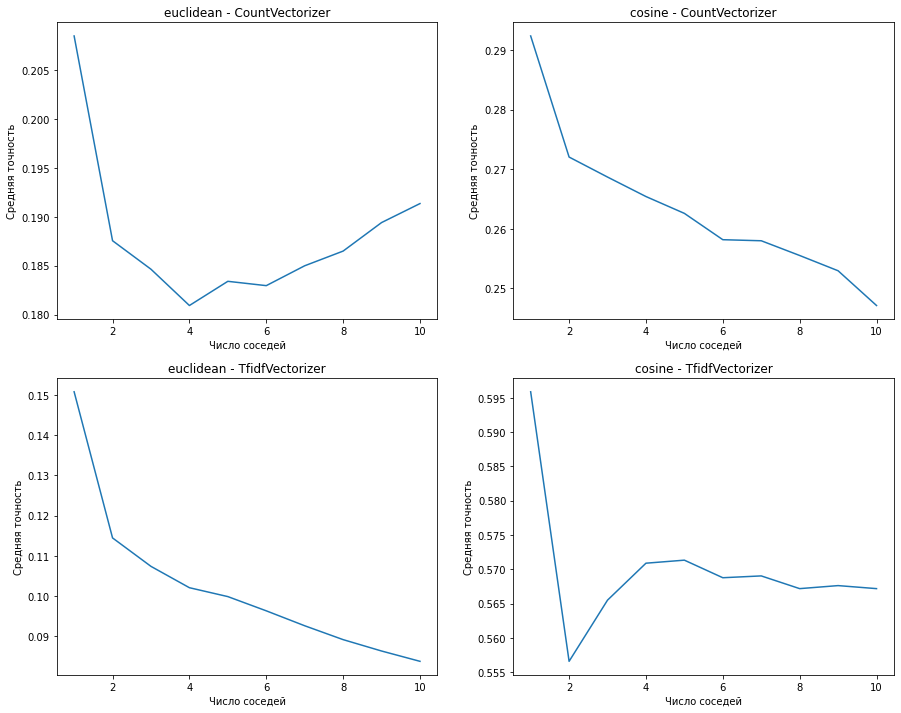

In [29]:
fig = plt.figure(figsize= (15,12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222) 
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.plot(range(1, 11), scores1)
ax1.set_xlabel('Число соседей')
ax1.set_ylabel('Средняя точность')
ax1.set_title('euclidean - CountVectorizer')

ax2.plot(range(1, 11), scores2)
ax2.set_xlabel('Число соседей')
ax2.set_ylabel('Средняя точность')
ax2.set_title('cosine - CountVectorizer')

ax3.plot(range(1,11), scores3)
ax3.set_xlabel('Число соседей')
ax3.set_ylabel('Средняя точность')
ax3.set_title('euclidean - TfidfVectorizer')

ax4.plot(range(1,11), scores4)
ax4.set_xlabel('Число соседей')
ax4.set_ylabel('Средняя точность')
ax4.set_title('cosine - TfidfVectorizer')


Вывод: лучше всего - это tf-idf с косинусным расстоянием и числом соседей равным 1

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [30]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

data_test = newsgroups['data']
target_test = newsgroups['target']

connect_vectorizer = TfidfVectorizer()
train_X = connect_vectorizer.fit_transform(data)

vectorizer = TfidfVectorizer(vocabulary=connect_vectorizer.get_feature_names())
test_X = vectorizer.fit_transform(data_test)

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [31]:
my_clf = MyKNeighborsClassifier(n_neighbors=1, metric='cosine')
my_clf.fit(train_X, target)

predict = my_clf.predict(test_X)
accuracy_score(predict, target_test)

0.5047796070100903

Результат на тестовой выборке хуже чем на валидационной, что может быть связано с тем, что параметр количества соседей не оптимален для тестовой выборки, но оптимален для валидационной, а также, что пришлось взять для тестовой выборки словарь от тренировочной, что требовалось для подсчета расстояний